In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = "iclr"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [3]:
import torch
import numpy as np
import pickle 
import string
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

Connecting konstantin@134.2.168.16:3306
Schema name: konstantin_nnsysident_iclr


In [4]:
def find_number(text, c):
    number_list = re.findall(r'%s(\d+)' % c, text)
    if len(number_list) == 0:
        number = None
    elif len(number_list) == 1:
        number = int(number_list[0])
    else:
        raise ValueError('More than one number found..') 
    return number

def get_transfer(transfer_hashes):
    # prepare the Transfer table in a way that all the info about the transferred model is in the DataFrame. Just pd.merge (on transfer_fn and transfer_hash)
    # it then with the model that the transferred model was used for. 
    
    transfer = pd.DataFrame((Transfer & 'transfer_hash in {}'.format(tuple(transfer_hashes))).fetch())
    transfer = pd.concat([transfer, transfer['transfer_config'].apply(pd.Series)], axis = 1).drop('transfer_config', axis = 1)

    restriction = transfer.rename(columns = {'t_model_hash': 'model_hash', 't_dataset_hash': 'dataset_hash', 't_trainer_hash': 'trainer_hash'})            
    restriction = restriction[['model_hash', 'dataset_hash', 'trainer_hash']].to_dict('records')

    tm = pd.DataFrame((TrainedModel * Dataset * Seed & restriction).fetch()).rename(
        columns = {'model_hash': 't_model_hash', 'trainer_hash': 't_trainer_hash', 'dataset_hash': 't_dataset_hash'})               
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['t_model_hash', 't_trainer_hash', 't_dataset_hash'])

    transfer = pd.merge(transfer, tm, how='inner', on=['t_model_hash', 't_trainer_hash', 't_dataset_hash'])
    transfer = pd.concat([transfer, transfer['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
    transfer.columns = ['t_' + col if col[:2] != 't_' and col[:8] != 'transfer'  else col for col in transfer.columns]
    transfer = transfer.sort_values(['t_multi_match_n', 't_image_n', 't_multi_match_base_seed', 't_image_base_seed'])
    return transfer

# Directly trained

In [26]:
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set', 
                    'Real, Direct, se2d_fullSXF, 4-set',
                    "Real, Direct, share_features=False, se2d_fullgaussian2d, 4-set", 
                    'Real, Direct, share_features=True, se2d_fullSXF, 4-set']
names = ['Gaussian w/ f-s', 'Factorized w/o f-s', 'Gaussian w/o f-s', 'Factorized w/ f-s'] 
 
# Fetch data
data = pd.DataFrame()
for experiment_name, name in zip(experiment_names, names):
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['Readout'] = name
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)#.drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'].isin([50, 500, 3597])]
#data.replace({'Readout': {'spatialxfeaturelinear':'factorized ', 'fullgaussian2d':'gaussian', 'pointpooled':'Point-Pooled'}}, inplace=True)

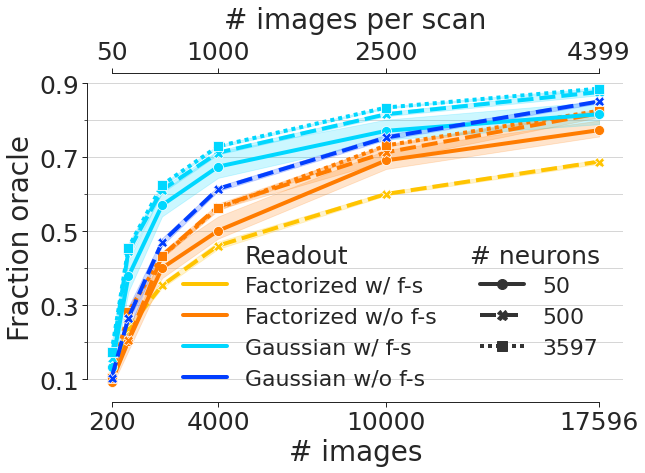

In [136]:
scoring_measure = "fraction_oracle"
palette = {key: sns.color_palette('bright')[col_index] for key, col_index in zip(np.unique(data.Readout), (8, 1, 9, 0))}

title = 'Direct training - readout comparison'
    
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Readout", 
                    style="# neurons",
                    kind="line",
                    data=data,
                    markers=True,
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
        
    ax2 = ax.twiny()
    ax2.set_xlim(tuple(x/4 for x in ax.get_xlim()))
    ax2.set_xticks(ax.get_xticks()/4)
    ax2.tick_params(labelsize=25)
    ax2.set_xlabel("# images per scan", fontsize=28, labelpad=12)
    
    
    sns.despine(trim=True, top=False)
    plt.tight_layout()
    
    idx = [ 1, 2, 3, 4, 6, 7, 8]
    h, l = ax.get_legend_handles_labels()
    h = [h[i] for i in idx]
    l = [l[i].capitalize() for i in idx]
    g._legend.remove()
    g.fig.legend(h,l, ncol=2, frameon=False, bbox_to_anchor=(0.4, 0.23, 0.5, 0.2), fontsize=22)
    
    # add title to the legend
    ax.text(4950, .415, "Readout", fontsize=25, )
    ax.text(13000, .415, "# neurons", fontsize=25)
    
    #g.fig.savefig('figures/' + title.title().replace(" ", "").replace(",", "-") + '.pdf', dpi=150, bbox_inches='tight')

# Transfer: Condition comparison

In [189]:
# direct data
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set, last 1000 neurons', 'Real, Direct, se2d_fullSXF, 4-set, last 1000 neurons']
# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 1000]
data.replace({'Readout': {'fullSXF':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
direct_data = data.copy()
direct_data['Condition'] = "direct"


# full readout data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (sameNI), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (sameNI), share_features=False, se2d_fullSXF, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data['t_image_n'] = data['t_image_n'] * 4
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data = data.rename(columns = {'multi_match_n': '# neurons', 't_image_n': "# images"})
data = data.loc[data['# neurons'] == 1000]
data.replace({'Readout': {'fullSXF':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
full_readout_data = data.copy()
full_readout_data['Condition'] = "diff-core/best-readout"


# full core data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best), share_features=False, se2d_fullSXF, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 1000]
data.replace({'Readout': {'fullSXF':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
full_core_data = data.copy()
full_core_data['Condition'] = "best-core/diff-readout"


data = pd.concat([direct_data, full_readout_data, full_core_data], sort=True)

In [ ]:
title = 'condition comparison'
scoring_measure = "fraction_oracle" 
sns.set_context("paper")        
col_order = ['Factorized readout ', 'Gaussian readout']
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,6,8) ]


paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.5), sns.axes_style('ticks'):        
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Condition", 
                    col="Readout",
                    col_order=col_order,
                    kind="line",
                    marker="o",
                    data=data,
                    palette=palette, 
                    height=5, 
                    aspect=.9)          
       
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    g.axes[0,0].set_xlabel('# images')
    g.axes[0,1].set_xlabel('# images')
    g._legend.texts[0].set_text("")
    g._legend.set_bbox_to_anchor((.84, .39, .1, .1))
    
    for h in g._legend.legendHandles[1:]:
        h.set_linewidth(4)
        
    for label in g._legend.texts:
            label.set_size(20)
    
    for i, ax in enumerate(g.axes.flatten()): 
        #ax.set_title(ax.get_title()[10:])   
        
        ax.set_yticks(np.arange(0.1, 1.0, 0.1))
        ax.yaxis.grid(True)
        
        ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.text(0.5, 1.05, ax.get_title(),
                horizontalalignment='center',
                fontsize=26,
                transform=ax.transAxes)
        #ax.set_title("")
        
        ax.text(-0.1, 1.09, string.ascii_uppercase[i], transform=ax.transAxes, size=30, weight='bold') 
        
        if i > 0:
            ax.set(xlabel="")
        else:
            ax.set_xlabel("# images", fontsize=24)
            ax.set_ylabel("Fraction oracle", fontsize=24)
            ax.set_yticklabels(['0.1', '', '0.3', '', '0.5', '', '0.7', '', '0.9'])

        ax2 = ax.twiny()
        ax2.set_xlim(tuple(x/4 for x in ax.get_xlim()))
        ax2.set_xticks(ax.get_xticks()/4)
        ax2.tick_params(labelsize=15)
        ax2.set_xlabel("# images per scan", fontsize=15, labelpad=12)
    
    sns.despine(trim=True, top=False)
    plt.tight_layout()
    #g.fig.savefig('figures/' + title + '.pdf', dpi=150, bbox_inches='tight')

In [241]:
g.axes.flatten()[1].get_title()

''

In [250]:
ax.title

Text(0.5, 1.2634216974827357, 'Gaussian readout')

# Animal transfer

In [9]:
experiment_names = ["Real, Direct, random 128, se2d_fullgaussian2d, 20457-5-9",
                    "Real, Direct, random 64, se2d_fullgaussian2d, 20457-5-9",
                    "Real, taskdriven transfer (pretrained VGG), taskdriven_fullgaussian2d, 20457-5-9",
                    "Real, taskdriven transfer (random VGG), taskdriven_fullgaussian2d, 20457-5-9"]

new_names = ["random core 128", "random core 64", 'VGG16', 'random VGG16 ']

data = pd.DataFrame()
for experiment_name, new_name in zip(experiment_names, new_names):
    
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore * Experiments.Restrictions 
                         & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['transfer_description'] = new_name
    data = pd.concat([data, data_])
    
# Filter out best performing models over model seeds
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data = data.sort_values('score', ascending=False).drop_duplicates(['transfer_description', 
                                                                   'neuron_n',
                                                                   'image_n', 
                                                                   'neuron_base_seed',
                                                                   'image_base_seed']).sort_values(['transfer_description', 'neuron_n', 'image_n'])


data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore * Experiments.Restrictions 
                     & 'experiment_name="{}"'.format("Real, Direct, se2d_fullgaussian2d, 20457-5-9")).fetch())
data_['transfer_description'] = 'direct'
data_ = pd.concat([data_, data_['dataset_config'].apply(pd.Series)], axis = 1)
data = pd.concat([data, data_], sort=True)
 

experiment_names = ["Real, core_transfer (animal), se2d_fullgaussian2d, 11-S -> 20457-5-9", 
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 4-set -> 20457-5-9",
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 1-set -> 20457-5-9",
                    "Real, core_transfer (animal) no cortex, se2d_fullgaussian2d, 11-S -> 20457-5-9",
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 4-S diff IDs -> 20457-5-9"]

new_names = ['11-S', '4-S: matched', "1-S", "11-S: no cortex", '4-S: diff animals ']

for experiment_name, new_name in zip(experiment_names, new_names):
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_ = pd.concat([data_, data_['dataset_config'].apply(pd.Series)], axis = 1)
    data_['transfer_description'] = new_name
    data = pd.concat([data, data_], sort=True)
    
data = data.rename(columns = {'neuron_n': '# neurons', 'image_n': "# images"})
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)

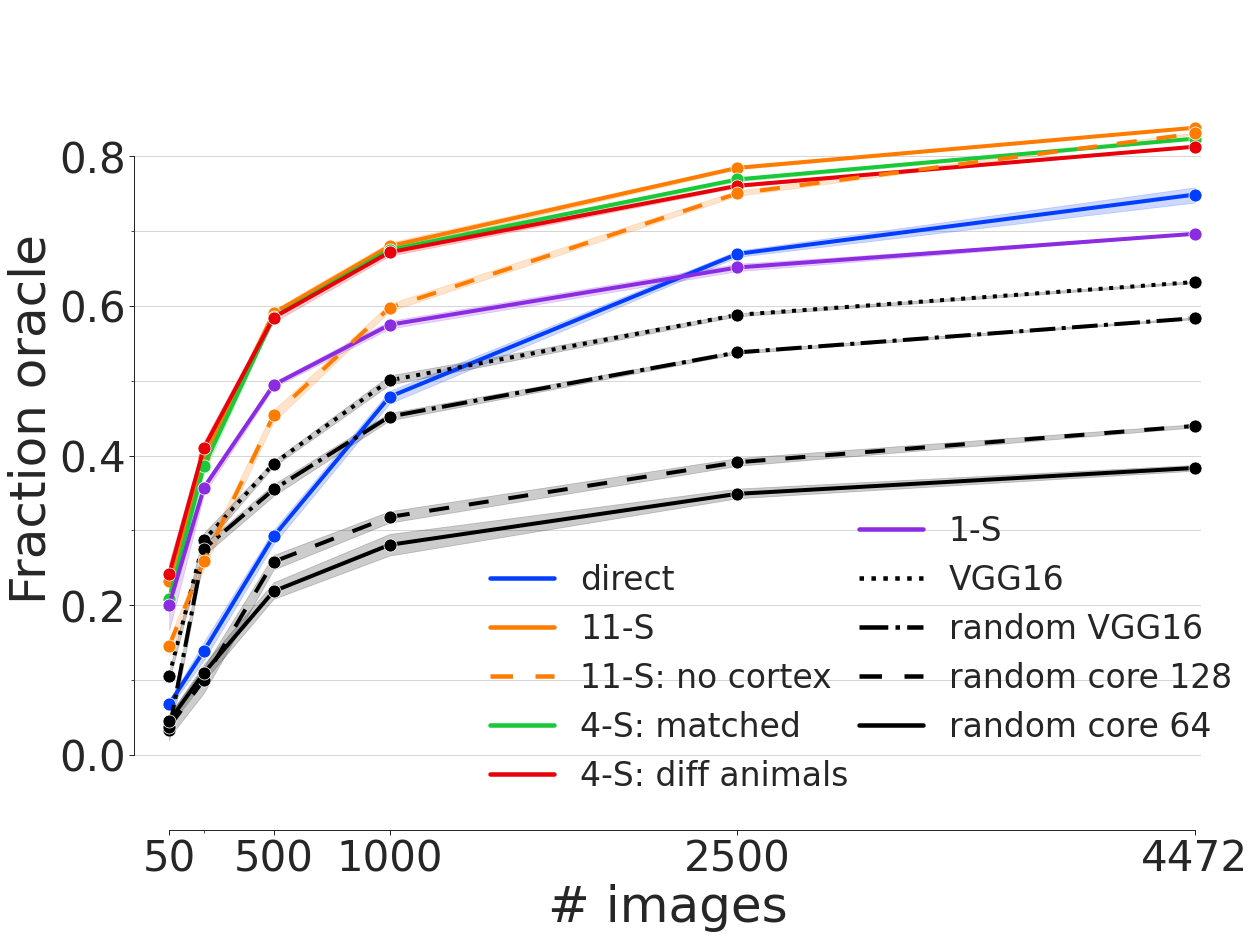

In [10]:
title = 'animal transfer'

palette = sns.color_palette('bright')[:2] + sns.color_palette('bright')[1:5]
palette += [(0., 0., 0.), (0.,0.,0.), (0.,0.,0.), (0., 0., 0.)]
scoring_measure = "fraction_oracle"
hues = ['direct', 
        '11-S', 
        '11-S: no cortex',
        '4-S: matched', 
        '4-S: diff animals ', 
        '1-S', 
        'VGG16', 
        'random VGG16 ',
        'random core 128',
        'random core 64'] 

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 13} #, 'axes.linewidth': 2  
with sns.plotting_context('paper', rc=paper_rc, font_scale=4.), sns.axes_style('ticks'):      
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="transfer_description", 
                    kind="line",
                    hue_order=hues,
                    data=data,
                    marker="o",
                    height=14,
                    aspect=.84,
                    palette=palette,
                   ) 
    ax = g.axes[0, 0]
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    
    
    h, l = ax.get_legend_handles_labels()
    g._legend.remove()
    leg = g.fig.legend(h, l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=32, columnspacing=.01)
    
    for i, style in zip([2, 6, 7, 8], [(0,(5,5)),':', '-.', (0,(5,5))]):
        g.axes[0,0].lines[i].set_linestyle(style)
        leg.legendHandles[i+1].set_linestyle(style)
    
    leg.texts[0].set_text("")
    g.axes[0,0].lines[2].set_zorder(100)
    
    for label in leg.texts:
        label.set_size(33)
        
    for h in leg.legendHandles[1:]:
        h.set_linewidth(4.5)
    
    ax = g.axes[0, 0]
    ax.set_ylim(-.1, 1)
    ax.set_xlim(-100, 4500)
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    ax.set_xticks(np.unique(data['# images'])[[0, 2, 3, 4, 5]])
    ax.set_xticks(np.unique(data['# images']), minor=True)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=50)
    ax.set_ylabel("Fraction oracle", fontsize=50)
    ax.tick_params(labelsize=42)
    
    sns.despine(trim=True)
    name = title.title().replace(" ", "").replace(",", "-")
    g.fig.tight_layout()
    #g.fig.savefig('figures/' + name + '.pdf', dpi=150,  bbox_inches='tight')